In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
import util.plot as plot
import util.download
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

In [3]:
import scipy.io as io
from torch.utils.data import TensorDataset
tfmp = T.Compose([T.ToPILImage(), T.Grayscale(num_output_channels=1),T.ToTensor(),T.Normalize(mean=(.5,), std=(.5,)),])

def mp2_create_dataset(folder_path):
    files = os.listdir(folder_path)
    tensors = []

    for file in files:
        print(file, end=" ")
        fname = DATA_DIR.joinpath(f'MPIIGaze/Data/Normalized/p00').joinpath( file)
        mat_data= io.loadmat(fname)
        data = mat_data['data'][0][0][1][0][0][1]
        dd = torch.from_numpy(data)
        imgs = [tfmp(im) for im in dd]
        t = torch.cat(imgs)
        tensors.append(t)

    t = torch.cat(tensors, dim=0)
    ds = TensorDataset(t)
    return ds

ds_mp2 = mp2_create_dataset(DATA_DIR.joinpath('MPIIGaze/Data/Normalized/p00'))

day02.mat day21.mat day08.mat day36.mat day34.mat day12.mat day29.mat day27.mat day31.mat day24.mat day17.mat day39.mat day37.mat day23.mat day14.mat day35.mat day13.mat day07.mat day20.mat day16.mat day26.mat day18.mat day33.mat day28.mat day19.mat day06.mat day09.mat day38.mat day01.mat day32.mat day03.mat day15.mat day05.mat day04.mat day11.mat day10.mat day25.mat day22.mat day30.mat 

In [6]:
ds_path = DATA_DIR.joinpath('UnityEyes_Linux/imgs')
tf = T.Compose([
    T.Grayscale(num_output_channels=1),
    # Resize to constant spatial dimensions
    T.CenterCrop((100,150)),
    T.Resize((36, 60)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,), std=(.5,)),
])
ds_unity = ImageFolder(os.path.dirname(ds_path), tf)

In [7]:
import simgan as gan

print("### Image size real")
x0 = ds_mp2[0][0]
x0 = x0.unsqueeze(0).unsqueeze(0).to(device)
print(x0.shape)

print("#### Discriminator")
dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

print("### Discriminator output shape")
d0_y = dsc(x0)
print(d0_y.shape)

print("### Image size sim")
x0, y0 = ds_unity[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

print("### Generator")
gen = gan.Generator(in_size=x0[0].shape).to(device)
print(gen)

# print("### Generator output shape")
xr = gen(x0)
print(xr.shape)

### Image size real
torch.Size([1, 1, 36, 60])
#### Discriminator
Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 5

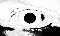

In [8]:
T.ToPILImage()(xr[0].cpu())

In [9]:
from dataset import SubsetDataset
ds = SubsetDataset(ds_mp2, ds_unity, 10000)

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(999)

# Hyperparams
hp = dict(
        batch_size=32, data_label=1, label_noise=0.3, lamb=0.5,
        discriminator_optimizer=dict(
            type='Adam', 
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
        generator_optimizer=dict(
            type='Adam',  
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
    )
    

# Data
dl_train = torch.utils.data.DataLoader(ds, batch_size=hp['batch_size'], shuffle=True, num_workers=1)

im_size = ds[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(im_size, out_channels=1).to(device)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
gen.apply(weights_init)
dsc.apply(weights_init)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated, x_generated, x_sim):
    return gan.generator_loss_fn(y_generated, x_generated, x_sim, hp['lamb'] ,hp['data_label'])

# Training
checkpoint_file = 'checkpoints/simgan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'data_label': 1, 'label_noise': 0.3, 'lamb': 0.5, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}}


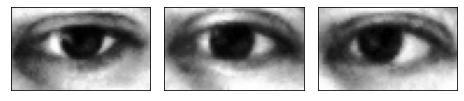

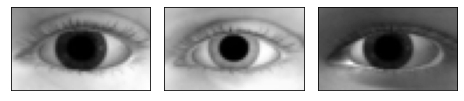

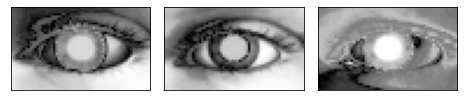

In [11]:
itr = iter(dl_train)
real, sim = next(itr)
with torch.no_grad():
    samples=gen(sim.cuda()).cpu()

_ = plot.tensors_as_gray_images(real[:3])
_ = plot.tensors_as_gray_images(sim[:3])
_ = plot.tensors_as_gray_images(samples[:3])

--- EPOCH 1/15 ---
  0%|          | 1/313 [00:00<03:27,  1.50it/s]Discriminator loss: 0.019793206825852394
Generator loss:     1.1606481075286865


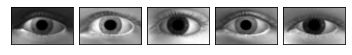

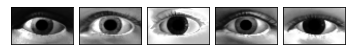

 32%|███▏      | 101/313 [00:48<01:41,  2.09it/s]Discriminator loss: 0.021491638204949624
Generator loss:     1.046063522891243


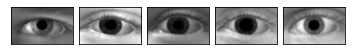

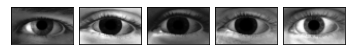

 64%|██████▍   | 201/313 [01:37<00:54,  2.07it/s]Discriminator loss: 0.027195878802979395
Generator loss:     1.0573761688536079


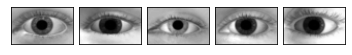

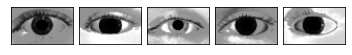

 96%|█████████▌| 301/313 [02:26<00:05,  2.07it/s]Discriminator loss: 0.02483855679854008
Generator loss:     1.063780934905689


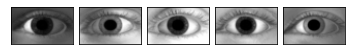

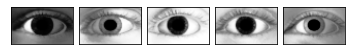

100%|██████████| 313/313 [02:32<00:00,  2.06it/s]
Discriminator loss: 0.024815218843007907
Generator loss:     1.0631830031498553
--- EPOCH 2/15 ---
  0%|          | 1/313 [00:00<03:17,  1.58it/s]Discriminator loss: 0.03742212429642677
Generator loss:     0.8892462849617004


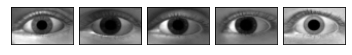

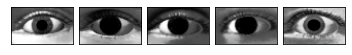

 32%|███▏      | 101/313 [00:49<01:42,  2.07it/s]Discriminator loss: 0.02557223156039225
Generator loss:     1.0723233937036873


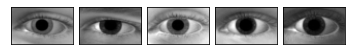

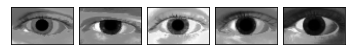

 64%|██████▍   | 201/313 [01:39<00:54,  2.05it/s]Discriminator loss: 0.02337433850920912
Generator loss:     1.0657919763925656


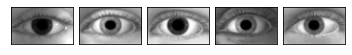

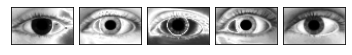

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.024121058413270006
Generator loss:     1.0710506185740727


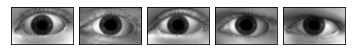

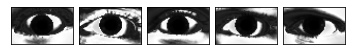

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.024268413969752982
Generator loss:     1.0729234631830893
--- EPOCH 3/15 ---
  0%|          | 1/313 [00:00<03:13,  1.61it/s]Discriminator loss: 0.039394233375787735
Generator loss:     1.1766226291656494


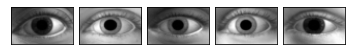

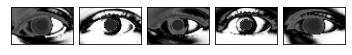

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.02216488788236338
Generator loss:     1.0635578242859038


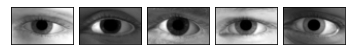

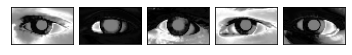

 64%|██████▍   | 201/313 [01:39<00:54,  2.04it/s]Discriminator loss: 0.04316880101504833
Generator loss:     1.107802231661716


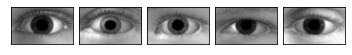

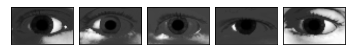

 96%|█████████▌| 301/313 [02:28<00:05,  2.03it/s]Discriminator loss: 0.0425814241000708
Generator loss:     1.1173998082793035


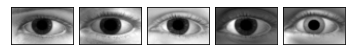

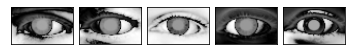

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.04265365816099337
Generator loss:     1.1155615444190967
--- EPOCH 4/15 ---
  0%|          | 1/313 [00:00<03:14,  1.60it/s]Discriminator loss: 0.013980787247419357
Generator loss:     0.9568948149681091


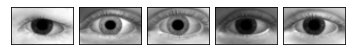

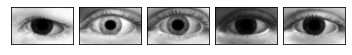

 32%|███▏      | 101/313 [00:49<01:43,  2.04it/s]Discriminator loss: 0.029171116599388938
Generator loss:     1.0909496870371376


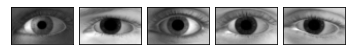

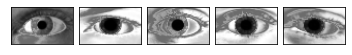

 64%|██████▍   | 201/313 [01:38<00:55,  2.03it/s]Discriminator loss: 0.030794611411512046
Generator loss:     1.108057892144616


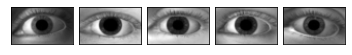

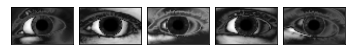

 96%|█████████▌| 301/313 [02:28<00:05,  2.04it/s]Discriminator loss: 0.02807136309144406
Generator loss:     1.0969413398112173


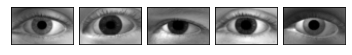

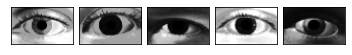

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.027790016084076306
Generator loss:     1.093881106224304
--- EPOCH 5/15 ---
  0%|          | 1/313 [00:00<03:16,  1.59it/s]Discriminator loss: 0.009285506792366505
Generator loss:     1.028678297996521


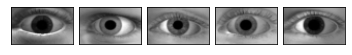

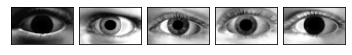

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.01639800172502009
Generator loss:     1.0409282681965593


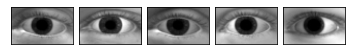

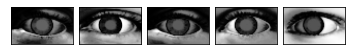

 64%|██████▍   | 201/313 [01:38<00:54,  2.05it/s]Discriminator loss: 0.01915941290923427
Generator loss:     1.0425473003838193


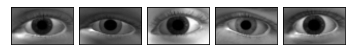

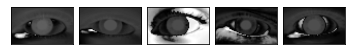

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.025509484702461335
Generator loss:     1.0778094149903206


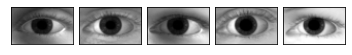

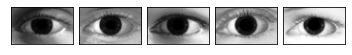

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.02517844436127847
Generator loss:     1.0752428492037251
Saved checkpoint.
--- EPOCH 6/15 ---
  0%|          | 0/313 [00:00<?, ?it/s]

/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj

  0%|          | 1/313 [00:00<03:14,  1.60it/s]Discriminator loss: 0.042439550161361694
Generator loss:     1.2169290781021118


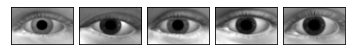

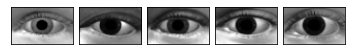

 32%|███▏      | 101/313 [00:49<01:43,  2.06it/s]Discriminator loss: 0.019317893219171184
Generator loss:     1.0433627083750054


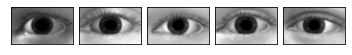

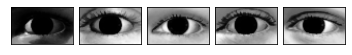

 64%|██████▍   | 201/313 [01:39<00:54,  2.05it/s]Discriminator loss: 0.02051951993252174
Generator loss:     1.0454217589909758


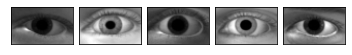

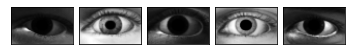

 96%|█████████▌| 301/313 [02:28<00:05,  2.02it/s]Discriminator loss: 0.02118156510838416
Generator loss:     1.045002480479966


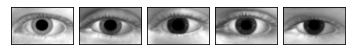

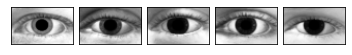

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.020767241188982568
Generator loss:     1.0437751913223023
--- EPOCH 7/15 ---
  0%|          | 1/313 [00:00<03:15,  1.60it/s]Discriminator loss: 0.006444510072469711
Generator loss:     1.062784194946289


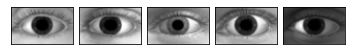

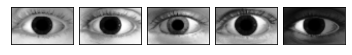

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.015413343689708722
Generator loss:     1.0260981350842089


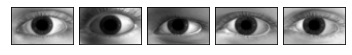

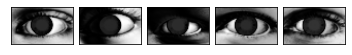

 64%|██████▍   | 201/313 [01:38<00:54,  2.06it/s]Discriminator loss: 0.02450741011074823
Generator loss:     1.048738161722819


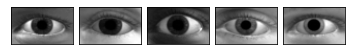

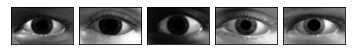

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.022522182747616474
Generator loss:     1.0477424705543392


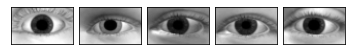

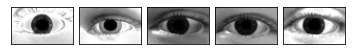

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.02219275115042949
Generator loss:     1.0478537533991634
--- EPOCH 8/15 ---
  0%|          | 1/313 [00:00<03:14,  1.60it/s]Discriminator loss: 0.012951661832630634
Generator loss:     1.0707114934921265


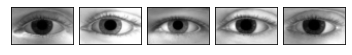

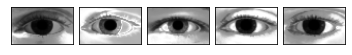

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.024840058887949084
Generator loss:     1.0905226398222516


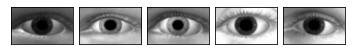

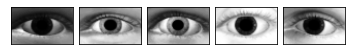

 64%|██████▍   | 201/313 [01:38<00:54,  2.05it/s]Discriminator loss: 0.020826163233735075
Generator loss:     1.0688534168461663


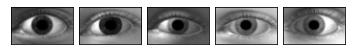

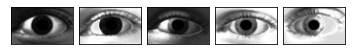

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.019618789197419124
Generator loss:     1.052475249450468


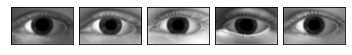

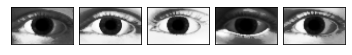

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.019346024792718762
Generator loss:     1.0519403318246714
--- EPOCH 9/15 ---
  0%|          | 1/313 [00:00<03:16,  1.59it/s]Discriminator loss: 0.008487634360790253
Generator loss:     0.9871084690093994


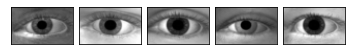

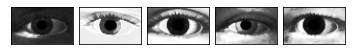

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.023403137541920093
Generator loss:     1.0665163751876001


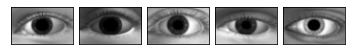

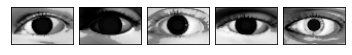

 64%|██████▍   | 201/313 [01:38<00:54,  2.06it/s]Discriminator loss: 0.022503438090618274
Generator loss:     1.0676620863563386


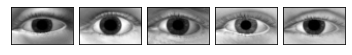

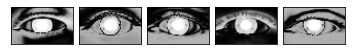

 96%|█████████▌| 301/313 [02:27<00:05,  2.05it/s]Discriminator loss: 0.022864935698414662
Generator loss:     1.0733245207225761


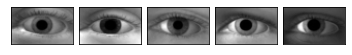

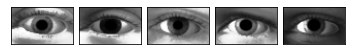

100%|██████████| 313/313 [02:33<00:00,  2.03it/s]
Discriminator loss: 0.022627731994948923
Generator loss:     1.0712415985406016
--- EPOCH 10/15 ---
  0%|          | 1/313 [00:00<03:19,  1.56it/s]Discriminator loss: 0.017889592796564102
Generator loss:     0.9063587188720703


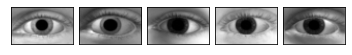

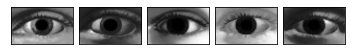

 32%|███▏      | 101/313 [00:50<01:43,  2.05it/s]Discriminator loss: 0.015417255009386208
Generator loss:     1.0492292949468782


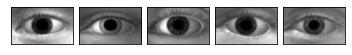

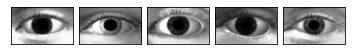

 64%|██████▍   | 201/313 [01:39<00:54,  2.05it/s]Discriminator loss: 0.014703222719572522
Generator loss:     1.0418409073530739


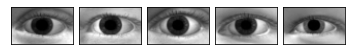

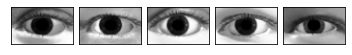

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.014712298937927795
Generator loss:     1.0481188134893626


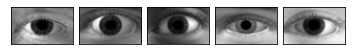

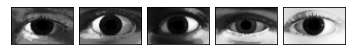

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.014516325679402382
Generator loss:     1.0468936111218632
Saved checkpoint.
--- EPOCH 11/15 ---
  0%|          | 1/313 [00:00<03:15,  1.59it/s]Discriminator loss: 0.03591742366552353
Generator loss:     1.1587045192718506


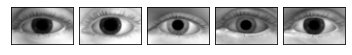

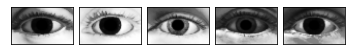

 32%|███▏      | 101/313 [00:49<01:44,  2.03it/s]Discriminator loss: 0.017821975707048826
Generator loss:     1.0500964109260258


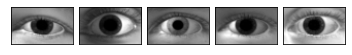

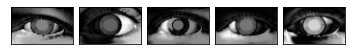

 64%|██████▍   | 201/313 [01:39<00:54,  2.06it/s]Discriminator loss: 0.019093760042520825
Generator loss:     1.0555411514951223


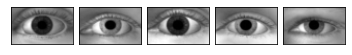

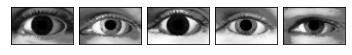

 96%|█████████▌| 301/313 [02:28<00:05,  2.04it/s]Discriminator loss: 0.0185075571491349
Generator loss:     1.0481378546980924


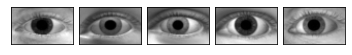

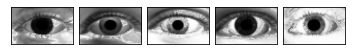

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.01810632051584629
Generator loss:     1.0474991927893398
--- EPOCH 12/15 ---
  0%|          | 1/313 [00:00<03:17,  1.58it/s]Discriminator loss: 0.012068875133991241
Generator loss:     1.0547051429748535


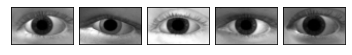

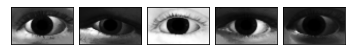

 32%|███▏      | 101/313 [00:49<01:45,  2.01it/s]Discriminator loss: 0.015307111879995111
Generator loss:     1.029075021790986


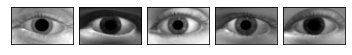

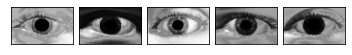

 64%|██████▍   | 201/313 [01:38<00:54,  2.05it/s]Discriminator loss: 0.014606725953899287
Generator loss:     1.0299544850392128


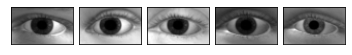

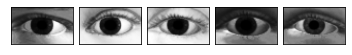

 96%|█████████▌| 301/313 [02:28<00:05,  2.06it/s]Discriminator loss: 0.01658538846450663
Generator loss:     1.0329499638753872


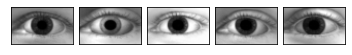

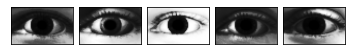

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.01636292375162982
Generator loss:     1.0334986305465332
--- EPOCH 13/15 ---
  0%|          | 1/313 [00:00<03:16,  1.59it/s]Discriminator loss: 0.010141640901565552
Generator loss:     1.0559839010238647


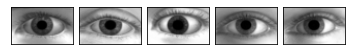

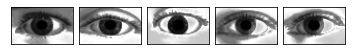

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.012250775469024436
Generator loss:     1.0213577475878273


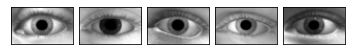

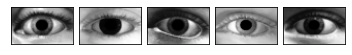

 64%|██████▍   | 201/313 [01:38<00:54,  2.06it/s]Discriminator loss: 0.032390732849850806
Generator loss:     1.0163596705417728


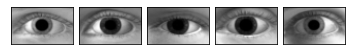

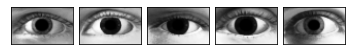

 96%|█████████▌| 301/313 [02:27<00:05,  2.06it/s]Discriminator loss: 0.027596690849032858
Generator loss:     1.018775963109989


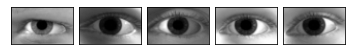

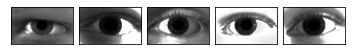

100%|██████████| 313/313 [02:33<00:00,  2.03it/s]
Discriminator loss: 0.02699127411633468
Generator loss:     1.0193343973769167
--- EPOCH 14/15 ---
  0%|          | 1/313 [00:00<03:13,  1.61it/s]Discriminator loss: 0.021931607276201248
Generator loss:     0.9549325704574585


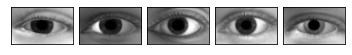

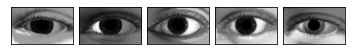

 32%|███▏      | 101/313 [00:49<01:43,  2.05it/s]Discriminator loss: 0.022238609726808155
Generator loss:     1.0287443375823522


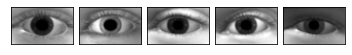

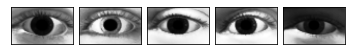

 64%|██████▍   | 201/313 [01:38<00:55,  2.02it/s]Discriminator loss: 0.017571093745075574
Generator loss:     1.0291473693515532


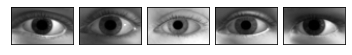

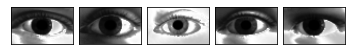

 96%|█████████▌| 301/313 [02:28<00:05,  2.05it/s]Discriminator loss: 0.018221319872774554
Generator loss:     1.0382469724183068


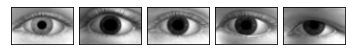

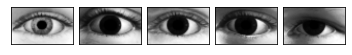

100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Discriminator loss: 0.018187616203432552
Generator loss:     1.0379899770687944
--- EPOCH 15/15 ---
  0%|          | 1/313 [00:00<03:17,  1.58it/s]Discriminator loss: 0.01405315101146698
Generator loss:     0.910449743270874


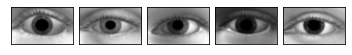

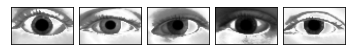

 32%|███▏      | 101/313 [00:49<01:43,  2.06it/s]Discriminator loss: 0.017125424474828167
Generator loss:     1.0271583742434436


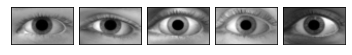

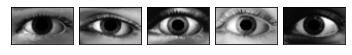

 64%|██████▍   | 201/313 [01:38<00:54,  2.05it/s]Discriminator loss: 0.016472343277807038
Generator loss:     1.0261339438495352


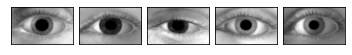

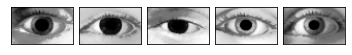

 96%|█████████▌| 301/313 [02:27<00:05,  2.05it/s]Discriminator loss: 0.018092752311323023
Generator loss:     1.0385924934152748


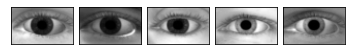

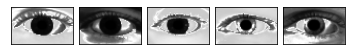

100%|██████████| 313/313 [02:33<00:00,  2.03it/s]
Discriminator loss: 0.017796695176601266
Generator loss:     1.0408087546071305
Saved checkpoint.


In [15]:
import IPython.display
import tqdm
from simgan import train_batch, save_checkpoint

num_epochs = 15

# if os.path.isfile(f'{checkpoint_file_final}.pt'):
#     print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
#     num_epochs = 0
#     gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
#     checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_real, x_sim) in enumerate(dl_train):
                x_real, x_sim = x_real.to(device), x_sim.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_real, x_sim)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()
                
                if batch_idx % 100 == 0:
                    print(f'Discriminator loss: {np.mean(dsc_losses)}')
                    print(f'Generator loss:     {np.mean(gen_losses)}')
                    
                    with torch.no_grad():
                        samples = gen(x_sim).cpu()
                        
                        fig, _ = plot.tensors_as_gray_images(x_sim[:5].cpu(), figsize=(6,2))
                        IPython.display.display(fig)
                        plt.close(fig)

                        fig, _ = plot.tensors_as_gray_images(samples[:5].cpu(), figsize=(6,2))
                        IPython.display.display(fig)
                        plt.close(fig)
                
        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
#         samples, labels = gen.sample(5, with_grad=False)
#         fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
#         IPython.display.display(fig)
#         plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

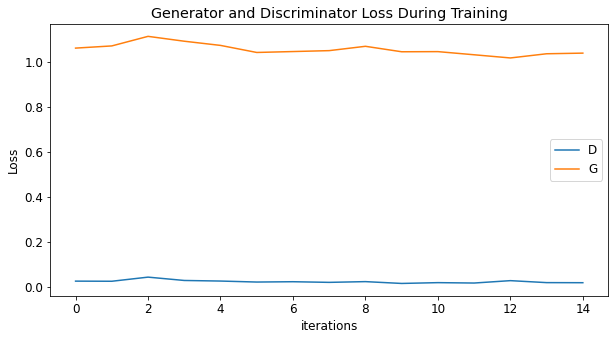

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(dsc_avg_losses,label="D")
plt.plot(gen_avg_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

*** Images Generated from best model:


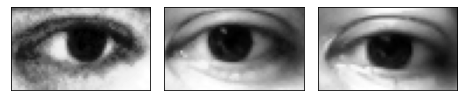

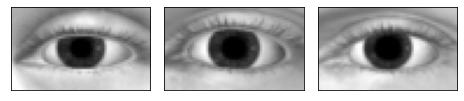

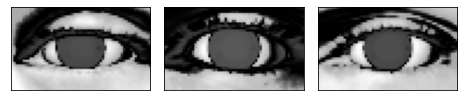

In [20]:
# itr = iter(dl_train)
real, sim = next(itr)
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')

with torch.no_grad():
    samples=gen(sim.cuda()).cpu()

_ = plot.tensors_as_gray_images(real[:3])
_ = plot.tensors_as_gray_images(sim[:3])
_ = plot.tensors_as_gray_images(samples[:3])

In [22]:
fig.savefig('./results/simgan')